In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

input_csv_file = 'feedforward_data_12V_Supercap.csv'  # Replace with your input CSV file name
raw_file = pd.read_csv(input_csv_file)
print("PULLEY_RADIUS =", "{:.6e}".format(raw_file.loc[0, "x"]))
raw_file = raw_file.iloc[1:raw_file.shape[0]].reset_index(drop=True)  # Remove first row

PULLEY_RADIUS = 3.572890e-02


#### Smooth outliers in raw file

Calculate discrepancies

In [93]:
outlier_csv = raw_file.copy()
coords = outlier_csv[['x','y']].to_numpy()

# Neighbor arrays
prev_coords = np.roll(coords, 1, axis=0)
next_coords = np.roll(coords, -1, axis=0)

# Distances
dist_prev = np.linalg.norm(coords - prev_coords, axis=1)
dist_next = np.linalg.norm(coords - next_coords, axis=1)

# Discrepancy measure
discrepancy = dist_prev*dist_next

Sort based on discrepancies

In [94]:
# Store it if you want to inspect
outlier_csv['discrepancy'] = discrepancy
outliers_sorted = outlier_csv.sort_values('discrepancy', ascending=False)

top_outliers = outliers_sorted.iloc[0:3,:]
print(top_outliers)

             x         y  Left_PWM  Right_PWM        dt  discrepancy
9998  0.503563  0.369320       0.0   0.499997  0.343760     0.000086
0     0.599239  0.471824       0.0  -0.499997  0.250008     0.000005
2001  0.782846  0.524773       0.0  -0.499997  0.468764     0.000003


In [6]:
# for index in top_outliers.index:
#     if index == 0 or index == len(coords) - 1:
#         continue  # Skip first and last rows
#     print(raw_file.iloc[index-1:index+2,:])
#     print("----------------------------")

Replace outliers

In [7]:
# --- Vectorized replacement ---
# Note: 
threshold = 1e-4 # <-- choose your threshold here

mask = discrepancy > threshold

# Compute neighbor averages
avg_neighbors = (prev_coords + next_coords) / 2

# Replace only where mask is True (excluding first/last index)
valid_mask = mask & (np.arange(len(coords)) > 0) & (np.arange(len(coords)) < len(coords)-1)

coords[valid_mask] = avg_neighbors[valid_mask]

# Put back into df
raw_file[['x','y']] = coords

Linear regression

In [95]:
window_size = 21   # must be odd for regression center
half_window = window_size // 2
chunk_size = 1000  # Number of rows per output file

In [96]:
# Add empty columns first
raw_file["X_Velocity_m_s_"] = np.nan
raw_file["Y_Velocity_m_s_"] = np.nan
raw_file["X_Accel_m_s2_"] = np.nan
raw_file["Y_Accel_m_s2_"] = np.nan

# --- Choose a segment  ---
for i in range(0, len(raw_file), chunk_size):
    # Select segment centered at i*1000
    start = max(0, i - half_window)
    end   = min(len(raw_file), i + half_window)

    segment = raw_file.iloc[start:end+1].reset_index(drop=True)

    # --- Extract arrays ---
    x = segment["x"].to_numpy()
    y = segment["y"].to_numpy()
    dt = segment["dt"].to_numpy()

    # --- Cumulative time (needed for regression) ---
    t = (np.cumsum(dt)-dt[0]) / 1000.0 # convert to seconds

    # ======================
    # 1) Linear regression method
    # ======================
    # Fit x(t), y(t) quadratically: ax*t^2 + bx + c
    coef_x, residual_x, _, _, _ = np.polyfit(t, x, 2, full=True)
    coef_y, residual_y, _, _, _ = np.polyfit(t, y, 2, full=True)

    ax, ay = 2*coef_x[0], 2*coef_y[0]     # accelerations
    vx, vy = coef_x[1], coef_y[1]         # initial velocities

    # Position of vector: center of window
    center_idx = (start + (end - start) // 2) * (i > 0)
    vel_x = ax * t + vx
    vel_y = ay * t + vy
    accel_x = np.full(len(vel_x), ax)
    accel_y = np.full(len(vel_y), ay)

    raw_file.loc[start:end, "X_Velocity_m_s_"] = vel_x
    raw_file.loc[start:end, "Y_Velocity_m_s_"] = vel_y
    raw_file.loc[start:end, "X_Accel_m_s2_"] = accel_x
    raw_file.loc[start:end, "Y_Accel_m_s2_"] = accel_y
    raw_file.loc[center_idx, "x"] = ax / 2 * t[center_idx - start]**2 + vx * t[center_idx - start] + coef_x[2]
    raw_file.loc[center_idx, "y"] = ay / 2 * t[center_idx - start]**2 + vy * t[center_idx - start] + coef_y[2]

    # raw_file.loc[center_idx, "X_Velocity_m_s_"] = vel_x[center_idx - start]
    # raw_file.loc[center_idx, "Y_Velocity_m_s_"] = vel_y[center_idx - start]
    # raw_file.loc[center_idx, "X_Accel_m_s2_"] = accel_x[center_idx - start]
    # raw_file.loc[center_idx, "Y_Accel_m_s2_"] = accel_y[center_idx - start]

Split CSV into chunks

In [97]:
batch_number = 1

# for chunk in pd.read_csv(input_csv_file, chunksize=chunk_size):
#     output_filename = f'feedforward_data_12V_{batch_number}.csv'
#     chunk.to_csv(output_filename, index=False)  # index=False prevents writing the DataFrame index
#     batch_number += 1

for i in range(0, len(raw_file), chunk_size):
    chunk = raw_file.iloc[i:i+chunk_size]
    output_filename = f'feedforward_data_12V_{batch_number}.csv'
    chunk.to_csv(output_filename, index=False)
    batch_number += 1

print(f"CSV file '{input_csv_file}' split into {batch_number - 1} files.")

CSV file 'feedforward_data_12V_Supercap.csv' split into 10 files.


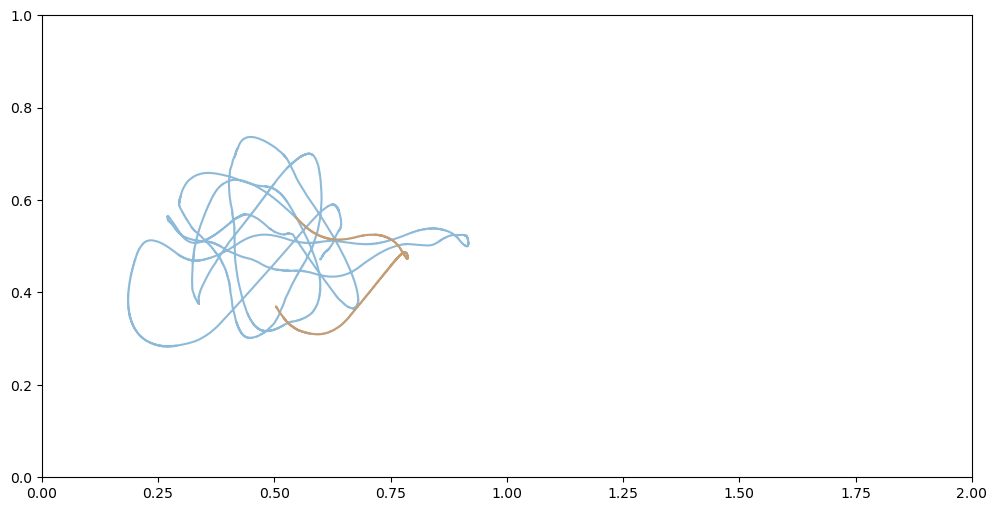

In [91]:
plt.figure(figsize=(12, 6))
plt.xlim(0, 2)
plt.ylim(0, 1)
# plt.figure(figsize=(8, 8))
# plt.xlim(0.3, 0.7)
# plt.ylim(0.3, 0.7)
plt.plot(raw_file['x'], raw_file['y'], label='Position', alpha=0.5)
path_chunk = pd.read_csv('feedforward_data_12V_10.csv')
plt.plot(path_chunk['x'], path_chunk['y'], label='Chunk Position', alpha=0.5)